This script explains the models that are used for training a physics informed neural networks (PINN). Furthermore, it explains how to use the classes in main.py to train the PINNs and reproduce the results. 

But first, what are PINNs? PINNs are neural networks that are combined with physical laws or principles to include existing knowledge about the underlying physics of a system in the training process. This improves the accuracy of predictions and allows training with limited data. 

In this work, three simple reactor models and one complex reactor model were set up to train the PINNs and compare the solution with the analytical solution by solving the ODEs with an ODE-solver of skipy.

In [1]:
# Import all libraries that are needed
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import os

First, we look at the simple model for solving a PFR. In this model, the kinetics of an equimolar equilibrium reaction is implemented:

$A\rightleftharpoons B$

The following mass balances are solved:

$\frac{dn_{\rm{A}}}{dz} = A \cdot (-r_{\rm{total}})$, $\quad\frac{dn_{\rm{B}}}{dz} = A \cdot (r_{\rm{total}})$

The total reaction rate is determined from the kinetic data of the forward reaction:

$k_{\rm{hin}} = k_{0,\rm{hin}} \cdot e^{\frac{E_{\rm{A,hin}}}{R\cdot T}}$

$r_{\rm{hin}} = k_{\rm{hin}} \cdot c_{\rm{A}}$

$r_{\rm{total}} = r_{\rm{hin}} \cdot\left(1-\frac{K(T)}{K(T=600\,\rm{K})}\right)$

There are three approaches for the heat balance: Isothermal, adiabatic and polytrop PFR.

Isothermal: $\frac{dT}{dz} = 0$

Adiabatic: $\frac{dT}{dz} = \frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\underbrace{\left(A\cdot\sum\limits_{j}r_{j}(-\Delta_{\rm{R}}H_{j})\right)}_{\substack{Reaction}}$

Polytropic: $\frac{dT}{dz} = \frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\left(\underbrace{A\cdot\sum\limits_{j}r_{j}(-\Delta_{\rm{R}}H_{j})}_{\substack{Reaction}} + \underbrace{U_{\rm{perV}}\cdot\left(T-T_{\rm{wall}}\right)}_{\substack{Heating/Cooling}}\right)$

Based on this model, we will now look at how the analytical solution is generated.

In [2]:
# Define parameters for the reactor model
reactor_lengths = np.linspace(0,10,num=100)
inlet_conds = [0.1,0,0.9,600] #x_A0,x_B0,x_N20,T0
bound_conds = [1,1] #p,u
species_conds = [6*1e8,1e5,30,4e4,10] #k1,cp,Hr,E_A,k0
reactor_conds = [100,0.1,10,600] #U_perv,A_reactor,L_reactor,T_bath

The defined parameters are not explained in more detail, because they are explained in the class. Important for the user is the thermo_state, which can be used to switch between the different heat balances, and plot_analytical_solution, which can be used to plot the solution. In the following, the analytical solution for the three cases is calculated and plotted.

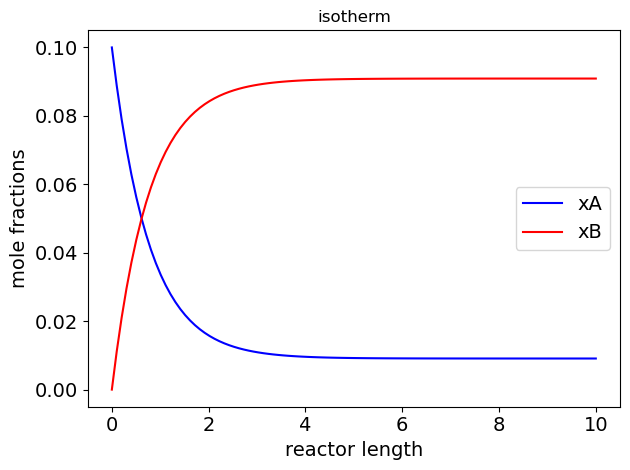

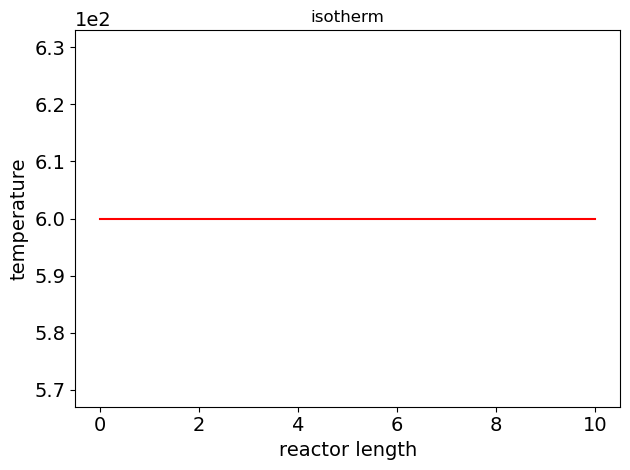

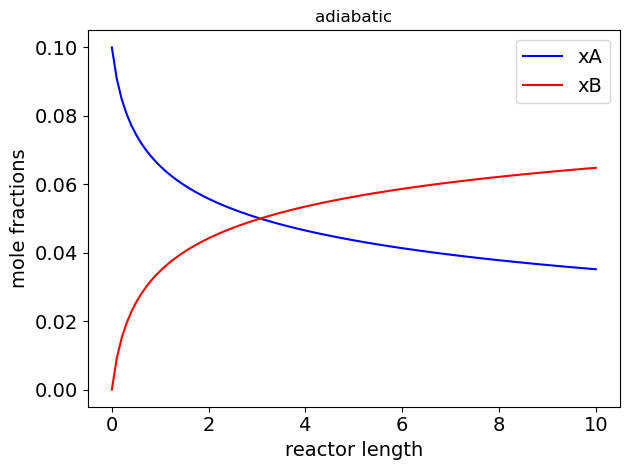

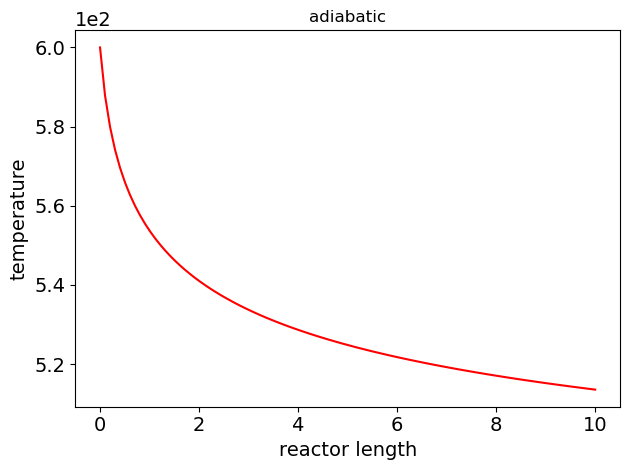

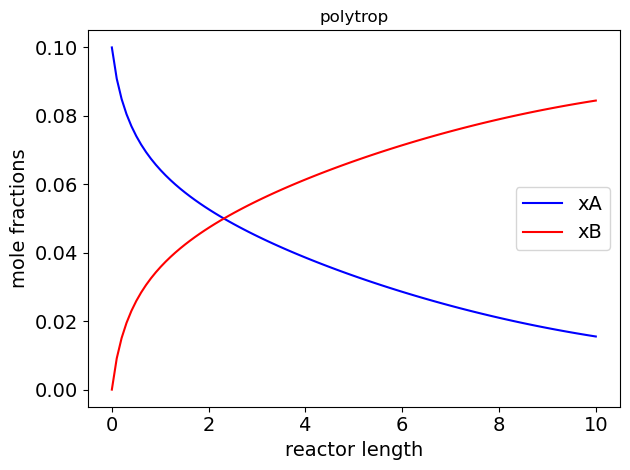

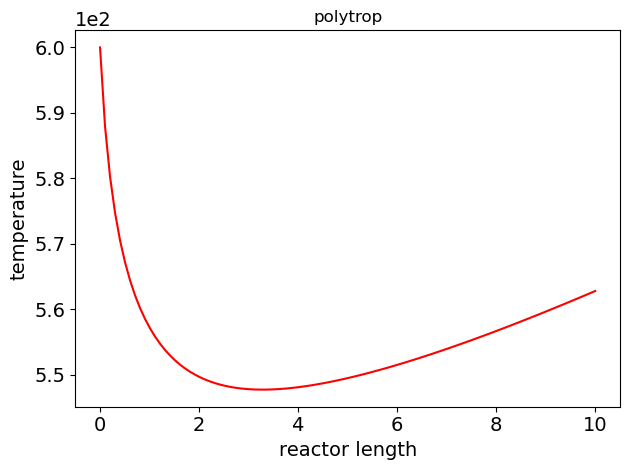

In [3]:
# Import the class
from simple_PFR.main import generate_data

# Generate an instance of the class
model = generate_data(inlet_conds, bound_conds, species_conds, reactor_conds)

# Generate data by using the method solve_ode
model.solve_ode(thermo_state='isotherm', reactor_lengths=reactor_lengths, plot=True)
model.solve_ode(thermo_state='adiabatic', reactor_lengths=reactor_lengths, plot=True)
model.solve_ode(thermo_state='polytrop', reactor_lengths=reactor_lengths, plot=True)

The curves show that the calculation of the analytical solution worked. Next, we focus on setting up the PINN. To do this, we will first look at what is behind the model.

How will the neural network be trained? First, a network architecture has to be selected and then the weights and biases are initialised, which are set randomly. Then the input data is sent through the network by propagating it through each layer. The activation functions in the neurons determine whether and how much a neuron is activated. This is followed by the training of the PINN. Here, the error is calculated using loss functions, where the loss function measures how well the neuornal network performs. Backpropagation is used to propagate the error backwards through the network to adjust the weights and biases with the chosen optimisation algorithm to minimise the error. During training, the process of forward and backward propagation is repeated several times until the number of epochs is reached. Afterwards, the predicted values from the forward propagation can be used to compare them with the analytical solution.

What network architecture is used here? The first layer contains one neuron, which contains the reactor lengths. The number of hidden layers and the number of neurons can be freely chosen here, but in this example few layers and neurons are needed to ensure high accuracy. In the last layer there are three neurons that contain the predicted solutions of the ODEs.

Which optimiser is used here? We use the limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) optimiser. The optimiser uses limited memory to deal efficiently with large models, and it is particularly useful for optimisation problems with many parameters. In our case, the learning rate is set to 1. In L-BFGS, the learning rate is handled differently than in traditional optimisers like gradient descent. Here it does not control the step size, but influences the "memory" of the optimiser and the amount of information it uses for updating. Furthermore, in our case, strict convergence criteria are set that must be undercut for the optimiser to consider the optimisation converged.

Which loss functions are used? In our case, the Mean Squared Error (MSE) is used as a loss function, which works well for regression problems. For the calculation of the total loss, the following loss functions are used and weighted with weighting factors so that the user can weight the losses himself:

$L_{\rm{GE,A}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{\dot n}_{\rm{A}}}{dz}-\left[A \cdot \left(-r_{\rm{total}}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})\right)\right]\right)$

$L_{\rm{GE,B}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{\dot n}_{\rm{B}}}{dz}-\left[A \cdot \left(r_{\rm{total}}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})\right)\right]\right)$

$L_{\rm{GE,T}} = \frac{1}{1000}\sum\limits_{i=1}^{N=1000}\left(\frac{d\hat{T}}{dz}-\left[\frac{1}{\sum\limits_{i} C_{\rm{p},i}\cdot\dot n_{i}}\cdot\left(A\cdot\sum\limits_{j}r_{j}(\hat{c}_{\rm{A}},\hat{c}_{\rm{B}},\hat{T})(-\Delta_{\rm{R}}H_{j})+ U_{\rm{perV}}\cdot\left(T-T_{\rm{wall}}\right)\right)\right]\right)$

$L_{\rm{IC,A}} = \left[\hat{\dot n}_{\rm{A}}(z=0)-\dot n_{\rm{A}}(z=0)\right]^{2}$

$L_{\rm{IC,B}} = \left[\hat{\dot n}_{\rm{B}}(z=0)-\dot n_{\rm{B}}(z=0)\right]^{2}$

$L_{\rm{IC,T}} = \left[\hat{T}(z=0)-T(z=0)\right]^{2}$

$L_{\rm{AB}} = w_{\rm{IC,AB}}\cdot\left(L_{\rm{IC,A}}+L_{\rm{IC,B}}\right)+w_{\rm{GE,AB}}\cdot\left(L_{\rm{GE,A}}+L_{\rm{GE,B}}\right)$

$L_{\rm{T}} = w_{\rm{IC,T}}*L_{\rm{IC,T}}+w_{\rm{GE,T}}*L_{\rm{GE,T}}$

$L_{\rm{total}} = w_{\rm{AB}}\cdot L_{\rm{AB}} + w_{\rm{T}}\cdot L_{\rm{T}}$

Here, the variables $\hat{\dot n}_{\rm{A}}$, $\hat{\dot n}_{\rm{B}}$, $\hat{c}_{\rm{A}}$, $\hat{c}_{\rm{B}}$ and $\hat{T}$ are predicted by the neural network $N(z)$. In the following section, the neural network is trained with the previous model:

In [ ]:
# Define parameters for the neural network
input_size_NN = 1
hidden_size_NN = 32
output_size_NN = 3
num_layers_NN = 3
num_epochs = 1000
weight_factors = [1e3,1,1,1,1,1] #w_AB,w_T,w_GE_AB,w_GE_T,w_IC_AB,w_IC_T
epsilon = 0 #epsilon=0: without causal training, epsilon!=0: with causal training
plot_interval = False # Plotting during NN-training

The variables input_size_NN, hidden_size_NN and output_size_NN specify the number of neurons in the corresponding layers. The variable num_layers_NN indicates the number of hidden layers and the variable num_epochs indicates the number of epochs in the training. The weighting factors are initially all set to 1 and will be varied later. The variable epsilon belongs to the causal algorithm, which will be explained in more detail later. So that it does not change the loss function, it is set to 0. The variable plot_interval specifies the interval of epochs at which the plots are created. These are stored in a "plots" folder generated by the program and can be examined during the training. For illustrative purposes, the plots are not created here, but examples are inserted. 

Was fehlt noch im ersten Teil?
- Code mit Training ohne causal Training durchführen.
- gegenbenenfalls Gif einfügen zum neuronalen Training
- Gewichtungsfaktoren anpassen und code nochmal durchführen
- gegenbenenfalls Gif einfügen zum neuronalen Training
- Causal Training mit Formeln erklären
- Code mit causal Training durchführen
- gegenbenenfalls Gif einfügen zum neuronalen Training

Danach geht es zum zweiten Reaktor.
- Hier alles neue genauso demonstrieren, erklären und mit Formeln belegen, aber nichts wiederholen, was schon erklärt wurde.